# Autoencoded U-net






## Description

**Kaggle mean Intersection over Union** : 0.29

**Local test mean Intersection over Union**: 0.28

**Description**: Trying to use the encoder part of a pre-trained autoencoder (on training+test data) to build a U-Net for segmentation

**Motivation**: Try to improve the performance by using an Encoder from a pretrained Autoencoder since its feature could be more meaningful than a simple UNet. This performes even worse than an equally built U-Net trained using the same parameters only for segmentation. Probably the learned features from the Autoencoder training are not useful for segmentation tasks.

## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2


## Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

from datetime import datetime
from tensorflow.keras.metrics import MeanIoU

## Parameters

In [3]:
# Batch size
BATCH_SIZE = 64

# Set the learning rate for the optimizer
LR = 1e-3

# Set the number of epochs for training
EPOCHS = 20

# Number of classes
NUM_CLASSES = 5

# Callbacks patiences
ES_PATIENCE = 5

# Plateau patiences
LR_PLATEAU_PATIENCE = 5

## Utils

In [4]:
# Function used to augment the images by applying a flip
def random_flip(image, label, seed=None):
    image, label = tf.expand_dims(image, axis=-1), tf.expand_dims(label, axis=-1)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    image, label = tf.squeeze(image, axis=-1), tf.squeeze(label, axis=-1)
    return image, label

## Load Data

In [8]:
# Load the dataset
data = np.load("dataset/cleaned_dataset.npz")
test_set = data['test_set']

# Split the dataset in images and labels array
X = data['images']
y = data['labels']

In [9]:
# Normalize Data
X = (X-1)/254
test_set = (test_set-1)/254

# One-hot encoder the targets
y = tfk.utils.to_categorical(y, num_classes=5)

# Obtain autoencoder training data
X_autoencoder = np.concatenate([test_set, X], axis=0)
X_autoencoder_train, X_autoencoder_val = train_test_split(X_autoencoder, test_size=0.2)

In [10]:
# Obtain U-Net training data
# Split the dataset into training, test, and validation
train_img, test_img_local, train_lbl, test_lbl_local = train_test_split(X, y, test_size=0.2, random_state=seed)
X_UNet_train, X_UNet_val, X_UNet_train_lab, X_UNet_val_lab = train_test_split(train_img, train_lbl, test_size=0.2, random_state=seed)

In [11]:
# Function to create a dataset with batch and shuffle
def make_dataset(images,labels,batch_size, shuffle=True, augment=False, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))

    # Shuffle the dataset if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Augment the dataset if requested
    if augment:
        dataset = dataset.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [12]:
# Create the autoencoder training dataset
autoencoder_train_dataset =  make_dataset(X_autoencoder_train, X_autoencoder_train, batch_size=BATCH_SIZE, shuffle=True, augment=True, seed=seed)

# Create the autoencoder validation dataset
autoencoder_val_dataset =  make_dataset(X_autoencoder_val, X_autoencoder_val, batch_size=BATCH_SIZE, shuffle=False, augment=False, seed=seed)

# Create the training dataset
UNet_train_dataset = make_dataset(X_UNet_train, X_UNet_train_lab, batch_size=BATCH_SIZE, shuffle=True, augment=True, seed=seed)

# Create the validation dataset
UNet_val_dataset = make_dataset(X_UNet_val, X_UNet_val_lab, batch_size=BATCH_SIZE, shuffle=False, augment=False, seed=seed)

## Autoencoder

### Model Implementation

In [13]:
# Define the input shape based on the training data
INPUT_SHAPE = (*X_autoencoder.shape[1:],1)
OUTPUT_SHAPE = INPUT_SHAPE

In [14]:
# Definition of a U-net block
def unet_block(input_tensor, filters, kernel_size=3, stack=2, name=''):
    x = input_tensor

    # Apply Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + '-conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + '-bn' + str(i + 1))(x)
        x = tfkl.LeakyReLU(alpha=0.1, name=name + '-leaky_re_lu' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [15]:
def get_autoencoder():
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(INPUT_SHAPE, name='input_layer')

    # First UNet block
    x = unet_block(input_layer,32,name='encoder_b1')
    x = tfkl.MaxPooling2D(name='max_pool_1')(x)

    # Second UNet block
    x = unet_block(x,64,name='encoder_b2')
    x = tfkl.MaxPooling2D(name='max_pool_2')(x)

    # Third UNet block
    x = unet_block(x,128,name='encoder_b3')
    x = tfkl.MaxPooling2D(name='max_pool_3')(x)

    # Bottleneck
    bottleneck = unet_block(x,256,name='bottleneck')

    # First upsampling and UNet block
    x = tfkl.UpSampling2D(interpolation='bilinear')(bottleneck)
    x = unet_block(x, 128, name='decoder_b1')

    # Second upsampling and UNet block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = unet_block(x, 64, name='decoder_b2')

    # Third upsampling and UNet block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = unet_block(x, 32, name='decoder_b3')

    # Getting the right image size
    x = tfkl.Conv2D(1, 3, padding='same')(x)

    # Sigmoid activation
    output_layer = tfkl.Activation('sigmoid')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')
    return model

In [16]:
# Definition of the autoencoder
autoencoder = get_autoencoder()

# Print a detailed summary of the autoencoder
autoencoder.summary(expand_nested=True, show_trainable=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 64, 128, 1)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b1-conv1 (Conv2D)           │ (None, 64, 128, 32)          │           320 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b1-bn1 (BatchNormalization) │ (None, 64, 128, 32)          │           128 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b1-leaky_re_lu1 (LeakyReLU) │ (None, 64, 128, 32)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b1-conv2 (Conv2D)           │ (None, 64, 128, 32)          │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b1-bn2 (BatchNormalization) │ (None, 64, 128, 32)          │           128 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b1-leaky_re_lu2 (LeakyReLU) │ (None, 64, 128, 32)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pool_1 (MaxPooling2D)           │ (None, 32, 64, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b2-conv1 (Conv2D)           │ (None, 32, 64, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b2-bn1 (BatchNormalization) │ (None, 32, 64, 64)           │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b2-leaky_re_lu1 (LeakyReLU) │ (None, 32, 64, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b2-conv2 (Conv2D)           │ (None, 32, 64, 64)           │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b2-bn2 (BatchNormalization) │ (None, 32, 64, 64)           │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b2-leaky_re_lu2 (LeakyReLU) │ (None, 32, 64, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pool_2 (MaxPooling2D)           │ (None, 16, 32, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b3-conv1 (Conv2D)           │ (None, 16, 32, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b3-bn1 (BatchNormalization) │ (None, 16, 32, 128)          │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b3-leaky_re_lu1 (LeakyReLU) │ (None, 16, 32, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b3-conv2 (Conv2D)           │ (None, 16, 32, 128)          │       147,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ encoder_b3-bn2 (Batch

 Total params: 1,758,657 (6.71 MB)

 Trainable params: 1,755,841 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

### Training

In [17]:
# Model compilation with Adam as optimizer and mean squared error as loss function
autoencoder.compile(
    optimizer=tf.optimizers.Adam(LR),
    loss=tfk.losses.MeanSquaredError()
    )

In [19]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True
)

# Implementation of reduce learning rate on plateau
reduce_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=10,
    factor=0.1,
    min_lr=1e-5
)

callbacks = [early_stopping, reduce_on_plateau]

In [20]:
# Train the autoencoder model
history = autoencoder.fit(
    X_autoencoder_train,
    X_autoencoder_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_autoencoder_val, X_autoencoder_val),
    callbacks=callbacks,
    verbose=1
).history

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - loss: 0.0072 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0018 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0014 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0013 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0011 - val_loss: 9.5313e-04 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0010 - val_loss: 9.5604e-04 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.8709e-04 - val_loss: 9.7068e-04 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 9.4360e-04 - val_loss: 8.9946e-04 - learning_rate: 0.0010
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 9.0479e-04 - val_loss: 8.

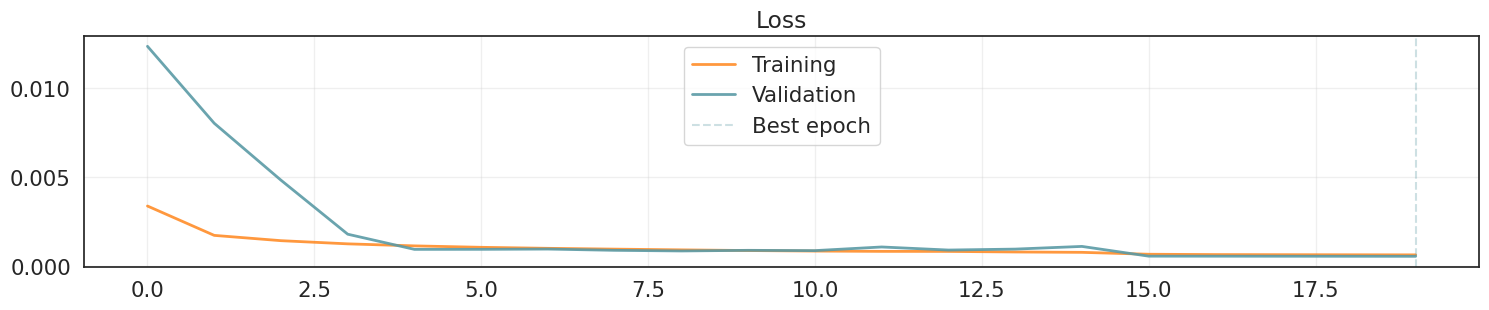

In [21]:
# Identify the best epoch based on minimum validation loss
best_epoch = np.argmin(history['val_loss'])

# Plot training and validation loss
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

(1, 64, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


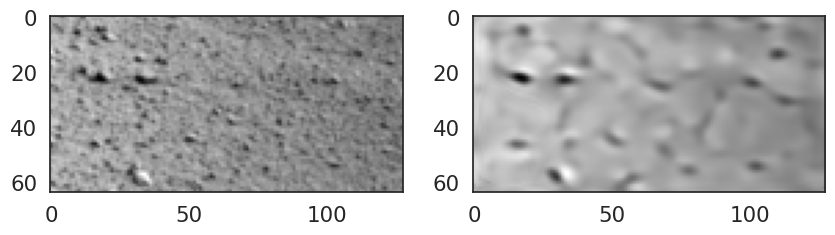

In [22]:
# Show an autoencoded image
idx = 300
img = X_autoencoder_val[idx]
input_batch = np.expand_dims(img,axis=0)
print(input_batch.shape)
out_img = autoencoder.predict(input_batch)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(out_img[0],cmap='gray')
plt.show()

In [23]:
# Save the trained model to a file with the loss included in the filename
model_filename = f'autoencoder_v1.keras'
autoencoder.save(f'models/{model_filename}')

## Model implementation

In [24]:
# Load the pretrained autoencoder
# autoencoder = tfk.models.load_model("models/autoencoder_v1.keras")
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b1-conv1 (Conv2D)            │ (None, 64, 128, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b1-bn1 (BatchNormalization)  │ (None, 64, 128, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b1-leaky_re_lu1 (LeakyReLU)  │ (None, 64, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b1-conv2 (Conv2D)            │ (None, 64, 128, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b1-bn2 (BatchNormalization)  │ (None, 64, 128, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b1-leaky_re_lu2 (LeakyReLU)  │ (None, 64, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_1 (MaxPooling2D)            │ (None, 32, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b2-conv1 (Conv2D)            │ (None, 32, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b2-bn1 (BatchNormalization)  │ (None, 32, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b2-leaky_re_lu1 (LeakyReLU)  │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b2-conv2 (Conv2D)            │ (None, 32, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b2-bn2 (BatchNormalization)  │ (None, 32, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b2-leaky_re_lu2 (LeakyReLU)  │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_2 (MaxPooling2D)            │ (None, 16, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b3-conv1 (Conv2D)            │ (None, 16, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b3-bn1 (BatchNormalization)  │ (None, 16, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b3-leaky_re_lu1 (LeakyReLU)  │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b3-conv2 (Conv2D)            │ (None, 16, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b3-bn2 (BatchNormalization)  │ (None, 16, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_b3-leaky_re_lu2 (LeakyReLU)  │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,270,341 (20.10 MB)

 Trainable params: 1,755,841 (6.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 3,511,684 (13.40 MB)

In [25]:
# Freeze and get the layers to link through skip
for layer in autoencoder.layers:
    layer.trainable = False

input_layer = autoencoder.get_layer("input_layer")
down_1 = autoencoder.get_layer("encoder_b1-leaky_re_lu2")
down_2 = autoencoder.get_layer("encoder_b2-leaky_re_lu2")
down_3 = autoencoder.get_layer("encoder_b3-leaky_re_lu2")
bottleneck_out = autoencoder.get_layer("bottleneck-leaky_re_lu2")

print("Input shape:",input_layer.output.shape)
print("Down_1 shape:",down_1.output.shape)
print("Down_2 shape:",down_2.output.shape)
print("Down_3 shape:",down_3.output.shape)
print("Bottleneck out Shape:",bottleneck_out.output.shape)

Input shape: (None, 64, 128, 1)
Down_1 shape: (None, 64, 128, 32)
Down_2 shape: (None, 32, 64, 64)
Down_3 shape: (None, 16, 32, 128)
Bottleneck out Shape: (None, 8, 16, 256)


In [26]:
# Definition of the model
input_shape = (64, 128, 1)
seed = seed

u1 = tfkl.UpSampling2D()(bottleneck_out.output)
u1 = tfkl.Concatenate()([u1, down_3.output])
u1 = unet_block(u1, 128, name='up_block1_')

u2 = tfkl.UpSampling2D()(u1)
u2 = tfkl.Concatenate()([u2, down_2.output])
u2 = unet_block(u2, 64, name='up_block2_')

u3 = tfkl.UpSampling2D()(u2)
u3 = tfkl.Concatenate()([u3, down_1.output])
u3 = unet_block(u3, 32, name='up_block3_')

# Output Layer
output_layer = tfkl.Conv2D(5, kernel_size=1, padding='same', activation="softmax", name='aug_out_layer')(u3)

model = tf.keras.Model(inputs=input_layer.output, outputs=output_layer, name='UNet')

In [27]:
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b1-conv1       │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b1-bn1         │ (None, 64, 128, 32)  │          128 │ encoder_b1-conv1[0… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b1-leaky_re_l… │ (None, 64, 128, 32)  │            0 │ encoder_b1-bn1[0][… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b1-conv2       │ (None, 64, 128, 32)  │        9,248 │ encoder_b1-leaky_r… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b1-bn2         │ (None, 64, 128, 32)  │          128 │ encoder_b1-conv2[0… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b1-leaky_re_l… │ (None, 64, 128, 32)  │            0 │ encoder_b1-bn2[0][… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pool_1             │ (None, 32, 64, 32)   │            0 │ encoder_b1-leaky_r… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b2-conv1       │ (None, 32, 64, 64)   │       18,496 │ max_pool_1[0][0]    │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b2-bn1         │ (None, 32, 64, 64)   │          256 │ encoder_b2-conv1[0… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b2-leaky_re_l… │ (None, 32, 64, 64)   │            0 │ encoder_b2-bn1[0][… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b2-conv2       │ (None, 32, 64, 64)   │       36,928 │ encoder_b2-leaky_r… │    N    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ encoder_b2-bn2         │ (None, 32, 64, 64)   │          256 │ encoder_b2-conv2[0… │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 1,952,069 (7.45 MB)

 Trainable params: 775,653 (2.96 MB)

 Non-trainable params: 1,176,416 (4.49 MB)

## Training

In [28]:
# Defining the callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='meanIoU',
    mode='min',
    patience=ES_PATIENCE,
    restore_best_weights=True
)

reduce_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='meanIoU',
    mode='min',
    patience=LR_PLATEAU_PATIENCE,
    factor=0.1,
    min_lr=1e-5
)

callbacks = [early_stopping, reduce_on_plateau]

In [29]:
# Model compilation with Adam as optimizer and Dice as loss function
model.compile(
    loss=tfk.losses.Dice(),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=["accuracy",tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')])

In [34]:
# Actual training of the model with the given parameters
history = model.fit(
    UNet_train_dataset,
    epochs=EPOCHS,
    validation_data=UNet_val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3999 - loss: 0.6209 - meanIoU: 0.1763 - val_accuracy: 0.3751 - val_loss: 0.6546 - val_meanIoU: 0.1519 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3948 - loss: 0.6241 - meanIoU: 0.1751 - val_accuracy: 0.3729 - val_loss: 0.6574 - val_meanIoU: 0.1646 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3903 - loss: 0.6270 - meanIoU: 0.1749 - val_accuracy: 0.3732 - val_loss: 0.6549 - val_meanIoU: 0.1680 - learning_rate: 1.0000e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4168 - loss: 0.6026 - meanIoU: 0.1820 - val_accuracy: 0.3617 - val_loss: 0.6597 - val_meanIoU: 0.1648 - learning_rate: 1.0000e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3967 - loss: 0.6209 - meanIoU: 0.1742 - val_accuracy: 0.3654 - val_loss: 0.6510 - val_meanIoU: 0.1695 - learning_rate: 1.0000e-04


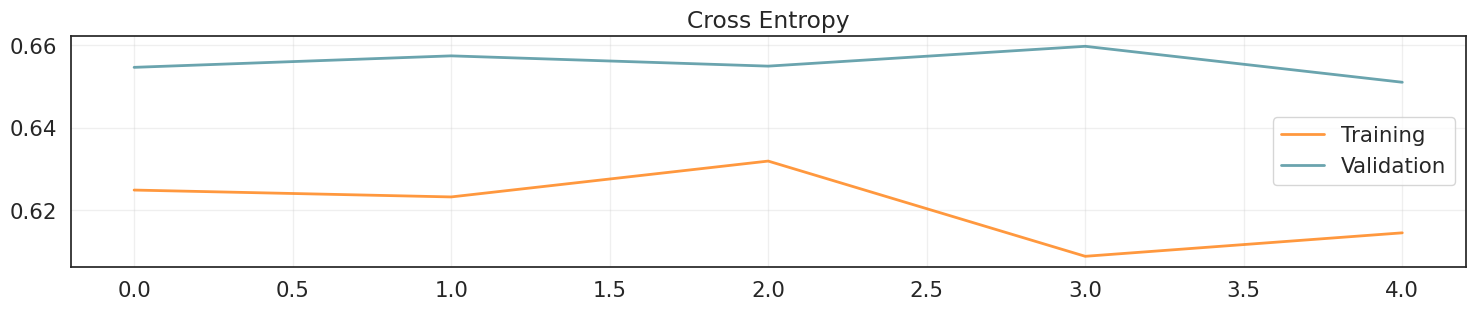

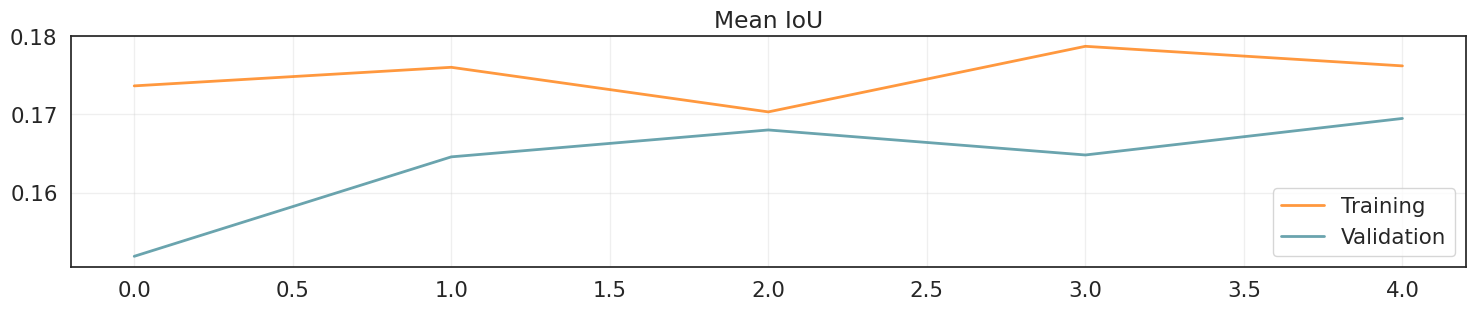

In [35]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['meanIoU'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_meanIoU'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean IoU')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Fine-tuning

In [36]:
# Fine tune everything
for layer in model.layers:
    layer.trainable = True

In [41]:
# Set the learning rate for the optimizer
LR = 1e-4

# Set the number of epochs for training
EPOCHS = 40

# Callbacks patiences
ES_PATIENCE = 20

# Plateau patiences
LR_PLATEAU_PATIENCE = 20

In [42]:
# Defining the callbacks
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_meanIoU',
    mode='min',
    patience=ES_PATIENCE,
    restore_best_weights=True
)

reduce_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_meanIoU',
    mode='min',
    patience=LR_PLATEAU_PATIENCE,
    factor=0.1,
    min_lr=1e-5
)

callbacks = [early_stopping, reduce_on_plateau]

In [43]:
# Compile the model
model.compile(
    loss=tfk.losses.Dice(),
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics=["accuracy",tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')])

In [44]:
# Train the model
history = model.fit(
    UNet_train_dataset,
    epochs=EPOCHS,
    validation_data=UNet_val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.4212 - loss: 0.5801 - meanIoU: 0.1945 - val_accuracy: 0.2414 - val_loss: 0.7586 - val_meanIoU: 0.0042 - learning_rate: 1.0000e-04
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4440 - loss: 0.5578 - meanIoU: 0.2106 - val_accuracy: 0.3351 - val_loss: 0.6629 - val_meanIoU: 0.0948 - learning_rate: 1.0000e-04
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4459 - loss: 0.5550 - meanIoU: 0.2084 - val_accuracy: 0.3663 - val_loss: 0.6321 - val_meanIoU: 0.1258 - learning_rate: 1.0000e-04
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4475 - loss: 0.5535 - meanIoU: 0.2084 - val_accuracy: 0.3909 - val_loss: 0.6069 - val_meanIoU: 0.1665 - learning_rate: 1.0000e-04
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4474 - loss: 0.5538 - meanIoU: 0.2086 - val_accuracy: 0.4269 - val_loss: 0.5713 - val_meanIoU: 0.1854 - learning_rate: 1.0000e-04
Epoch 6/40
25/25 ━━━━━━

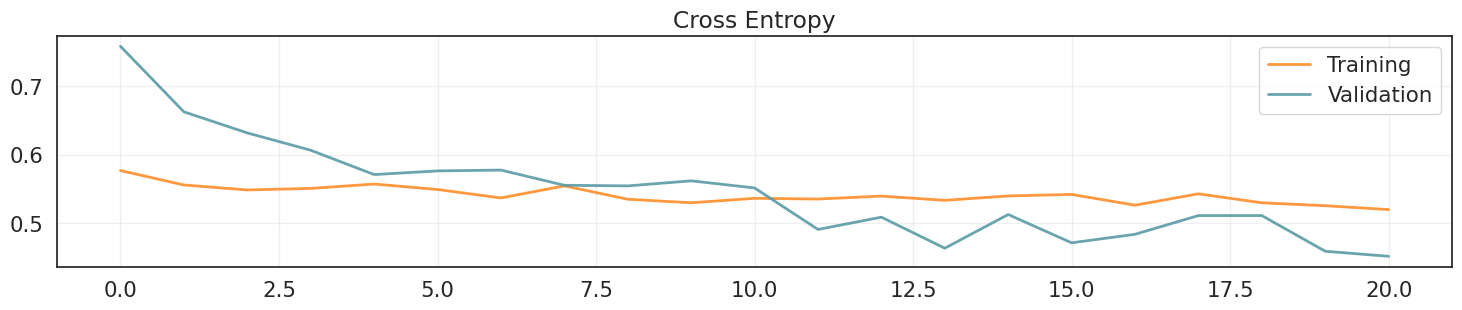

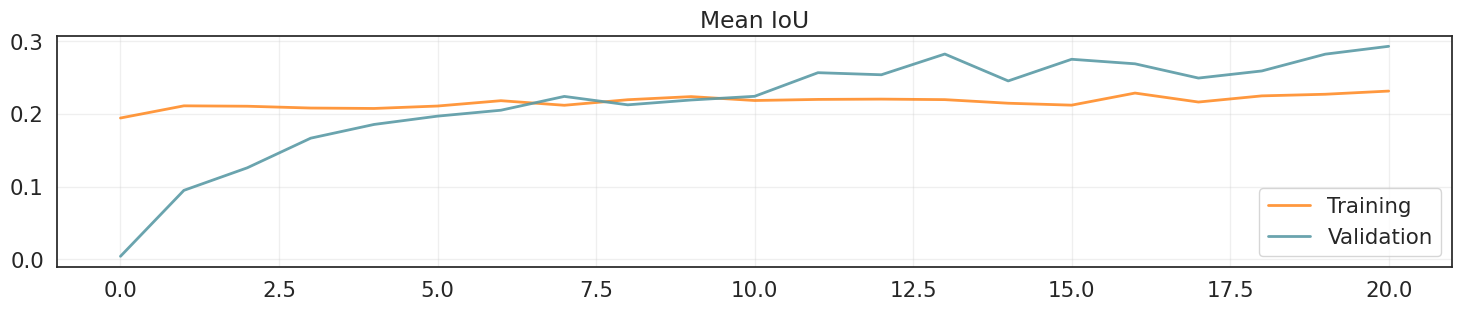

In [45]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['meanIoU'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_meanIoU'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean IoU')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Test Prediction and Final Evaluation

In [46]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(test_img_local, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_lbl_local = np.argmax(test_lbl_local, axis=-1)

In [47]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_lbl_local.flatten(), test_predictions.flatten())
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted', zero_division=0)
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calculate and display test set mean Intersection Over Union score
# one_hot_pred = tfk.utils.to_categorical(test_predictions, num_classes=NUM_CLASSES)
test_miou = MeanIoU(NUM_CLASSES)
test_miou.update_state(test_lbl_local, test_predictions)
test_miou = test_miou.result().numpy()
print(f'Mean Intersection over Union over the test set: {round(test_miou, 4)}')

Accuracy score over the test set: 0.2403
Precision score over the test set: 0.5699
Recall score over the test set: 0.2403
F1 score over the test set: 0.1038
Mean Intersection over Union over the test set: 0.05249999836087227


## Save

In [48]:
# Saving the model for testing and submission
current_time = datetime.now().strftime("%d|%m-%H:%M")
model_filename = f'UNet_{current_time}.keras'
print("Saved as :",model_filename)
model.save(f'models/{model_filename}', include_optimizer=False)

Saved as : UNet_14|12-16:03.keras


## Submission

In [49]:
# Predict the masks for the submission
preds = model.predict(test_set)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [50]:
# Converts segmentation predictions into a DataFrame format for Kaggle
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [51]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submissions/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)